In [649]:
%pylab
%matplotlib inline
%config InlineBackend.figure_format = "retina"
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
#from mpl_toolkits.mplot3d import Axes3D
import requests
import os
import csv
from astropy.io import fits
import itertools as IT
import pds
import urllib2
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import KMeans
from itertools import cycle
import collections
import pandas as pd

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [2]:
baseURL = 'http://pds-imaging.jpl.nasa.gov/w10n/'
dataURL = 'mer1-m-pancam-2-edr-ops-v1.0/mer1po_0xxx/data/'
product = 'edr'
formatURL = '?output=json'

data = {}
for sol in range(149,151):
    data[sol] = {}

for sol in data.keys():
    #print sol
    URL = '{baseURL}{dataURL}sol{sol}/{product}/'.format(baseURL=baseURL, dataURL=dataURL,
                                                         sol='{0:0>4}'.format(sol), product=product)
    try:
        allimg = requests.get(URL+formatURL).json()
        for img in allimg['leaves']:
            if 'eff' in img['name']:
                seq = img['name'][-13:-7]
                if not seq in data[sol].keys():
                    data[sol][seq] = [img['name']]
                else:
                    data[sol][seq]+=[img['name']]
    except:
        print URL+formatURL

In [918]:
def read_header(sol,img):
    """Returns the rover-frame pancam elevation and azimuth from the IMG header"""
    solday = "{0:0>4}".format(sol)
    URL = 'http://pds-imaging.jpl.nasa.gov/data/mer/opportunity/mer1po_0xxx/data/sol{num}/edr/{img}'.format(num=solday,img=img)
    open_URL = urllib2.urlopen(URL)
    f = open_URL.readlines()
    line_text = 'ROVER_DERIVED_GEOMETRY_PARMS'
    skip_cond = 'END_GROUP'
    j = 0
    for i,lines in enumerate(f):
        if skip_cond in lines:
            continue
        elif line_text in lines:
            j = i
            break
        else:
            continue
    open_URL.close()
    return float(f[j+1][36:-8]),float(f[j+2][36:-8])

def compare_imgs(sol,seq):
    '''Compares the telemetry data for images in a sol and seq and returns the images with matching
       telemetry data. If there is only one image in the sol and seq it alerts the user--this will
       later be modified as a skip condition. If there are no images with matching telemetry data
       then the user will be notified--this will also, later, be modified into a skip condition.'''
    if len(data[sol][seq]) <= 1:
        return 'There are 1 or less images. Try a different sol and seq combination.'
    telem = {}
    for i in data[sol][seq]:
        #print i
        elev,azi = read_header(sol,i)
        telem[i] = {}
        telem[i]['elevation'] = elev
        telem[i]['azimuth'] = azi
    candidates = []
    for i in data[sol][seq]:
        for j in data[sol][seq]:
            if i == j:
                continue
            elif telem[i]['elevation'] == telem[j]['elevation'] and telem[i]['azimuth'] == telem[j]['azimuth']:
                print '{i} | {j}'.format(i=telem[i],j=telem[j])
                if not i in candidates:
                    candidates.append(i)
    if len(candidates) == 0:
        return 'There are no matches. Try another sol and seq combination'
    else:
        return candidates
def viable_seq_sol(data):
    '''Evaluates the data dictionary for sol_day and sequence combinations of a suitable length to be evaluated
       by the compare_imgs function.'''
    viable = {}
    for sol_day in data.keys():
        if len(data[sol_day]) == 0:
            continue
        else:
            viable[sol_day] = {}
        for sequence in data[sol_day]:
            if len(data[sol_day][sequence]) <= 1:
                continue
            else:
                viable[sol_day][sequence] = data[sol_day][sequence]
    return viable 
'''-----Functions between the lines are subject to further review as of 01/19/2015 -----'''
def component_decomposition(component):
    '''Chunks a single eigenimage. Can have multiple eigenimages passed through it via "for" loop'''
    '''***Update needed to phase out components in favor of Zn***'''
    comp_decomp = {}
    for lat in range(len(component.T) - 4):
        comp_decomp[lat] = {}
        samples = []
        for lon in range(len(component) - 4):
            x_left = 0 + lon
            x_right = (4 - len(component)) + lon
            y_top = 0 + lat
            y_bot = (4 - len(component.T)) + lat
            sample = component[y_top:y_bot, x_left:x_right]
            samples.append(sample)
        comp_decomp[lat] = samples
    return comp_decomp

def threeD(comp_sample):
    agg_update = (np.array([X_Vals_f, Y_Vals_f, comp_sample.flatten()]).T)
    return agg_update

def kmeans_row(three_D):
    KM = KMeans(n_clusters=3, init='k-means++')
    KM_update = KM.fit_predict(three_D)
    return KM_update
'''------------------------------------01/19/2015--------------------------------------'''
def PCA(victim):
    'Performs principle component analysis over all images "R" (victims) of interest.'
    K,N = np.shape(victim)
    #mean_R = np.mean(R[6])
    mean_victim = np.mean(victim[len(victim)-1])
    S = np.cov(victim)
    ls,Phi = np.linalg.eigh(S)
    #reverse ls & Phi (by cols):
    ls = ls[::-1]
    Phi = (Phi.T[::-1]).T
    #normalizing factor:
    G = np.sqrt(np.diag(1./(N-1)/ls))
    #kl transform, normalization & clipping
    Z = np.dot(Phi.T,victim)
    Zn = np.float32(np.dot(G,Z))
    #print Zn[0]
    #print len(Zn[0])
    k,n = np.shape(Zn)
    #print k, n
    #print Zn
    return Zn

def xy_coord(arr):
    '''Produces x-y coordinate arrays based on the shape of the image (arr) being evaluated.
       ***unnecessary as of --01/18/2016-- use np.indices instead***'''
    img_RE = np.reshape(arr,(1016,1016))
    x_row = np.arange(len(img_RE), dtype = 'uint16')
    x_blank = np.zeros(img_RE.shape,dtype = 'uint8')
    X_Vals = np.add(x_row,x_blank)
    Y_Vals = np.transpose(X_Vals)
    X_f = X_Vals.flatten()
    Y_f = Y_Vals.flatten()
    return X_f, Y_f

def percentile_cut(input_arr): 
    '''Performs the percentile cut for the percentages listed in function perc_thresh for either an eigenimage
       or an image. --01/18/2016'''
    matches = collections.OrderedDict()
    threshs = perc_thresh(input_arr)
    input_squerr = np.reshape(input_arr,(rebuild))
    for key in threshs.keys():
        matches[key] = {}
        ylow,xlow = np.where(input_squerr <= threshs[key]['lower'])
        yhi,xhi = np.where(input_squerr >= threshs[key]['upper'])
        ycoords = np.concatenate([ylow,yhi])
        xcoords = np.concatenate([xlow,xhi])
        matches[key]['x'] = np.array(xcoords,dtype='uint16')
        matches[key]['y'] = np.array(ycoords,dtype='uint16')

    return matches

def R2Comp(xyhits,R):
    '''Uses the x and y coordinates from the eigenimages to locate those respective m-values from the image.
       --01/18/2016'''
    R_Mcache = collections.OrderedDict()
    R_sq = np.reshape(R,(1016,1016))
    for key in xyhits.keys():
        R_Mcache[key] = {}
        m_arr = []
        for x,y in zip(xyhits[key]['x'],xyhits[key]['y']):
            m_arr.append(R_sq[y][x])
        R_Mcache[key]['m'] = np.uint8(m_arr)
    return R_Mcache

def perc_thresh(img_or_comp):
    'returns the respective percentile cut threshold values for a single component or image'
    '**Image or component must be flattened**   --01/16/2016'
    perc_r = [99, 99.9, 99.99, 99.999]
    perc_l = [1, 0.1, 0.01, 0.001]
    Keys = ['99_1', '99.9_0.1', '99.99_0.01', '99.999_0.001']
    thresh = collections.OrderedDict()
    for i,key in enumerate(Keys):
        thresh[key] = {}
        if np.issubdtype(img_or_comp.dtype,uint8) == False:
            thresh[key]['upper'] = np.float32(np.percentile(img_or_comp, perc_r[i]))
            thresh[key]['lower'] = np.float32(np.percentile(img_or_comp, perc_l[i]))
        else:
            thresh[key]['upper'] = np.uint8(np.percentile(img_or_comp, perc_r[i]))
            thresh[key]['lower'] = np.uint8(np.percentile(img_or_comp, perc_l[i]))
    return thresh

def verify_R2Comp(xyhits,R_indiv):
    '''Uses the coordinates from the percentile cut for the 0th eigenimage to extract the m-values
       for those coordinates from the images. These m-values are compared against the percentile cut
       values for the images and the coordinates that meet the percentile cut criteria are returned.
       **xyhits must be taken from R[0] ONLY**
       --01/19/2016'''
    R_cache = R2Comp(xyhits,R_indiv)
    thresh = perc_thresh(R_indiv)
    R_cut = percentile_cut(R_indiv)
    R_m = R2Comp(R_cut,R_indiv)
    R_verified = collections.OrderedDict()
    for key in R_cache.keys():
        R_verified[key] = {}
        R_uniq_m = np.intersect1d(R_cache[key]['m'],R_m[key]['m'])
        x = []
        y = []
        for m in R_uniq_m:
            y1,x1 = np.where(np.reshape(R_indiv,rebuild) == m)
            if len(x) < 1:
                x.append(x1)
                y.append(y1)
            else:
                x = np.append(x,x1)
                y = np.append(y,y1)
        R_verified[key]['x'] = np.uint16(x)
        R_verified[key]['y'] = np.uint16(y)
        #R_verified[key]['m'] = m_arr
    return R_verified

def cosmicray_hits(key,R_ver_arr):
    '''Compares the values from each image to all the other images to determine which values in that image are
       unique. key is the percentile cut as defined in perc_thresh and R_ver_arr is the result of runnung
       verify_R2Comp. --01/20/2016'''
    cosmicray_hits = []
    for i in range(len(R_ver_arr)):
        xR = []
        yR = []
        xR = np.append(xR,R_ver_arr[i][key]['x'])
        yR = np.append(yR,R_ver_arr[i][key]['y'])
        xyR = np.array([xR,yR])
        xyR = xyR.T
        xyR = set(map(tuple,xyR))
        comparex2 = []
        comparey2 = []
        for j in range(len(R_ver_arr)):
            if i == j:
                continue
            else:
                comparex2 = np.append(comparex2,R_ver_arr[j][key]['x'])
                comparey2 = np.append(comparey2,R_ver_arr[j][key]['y'])
                xy = np.array([comparex2,comparey2])
                xy = xy.T
                xy = set(map(tuple,xy))
        xyR_inall = xyR.intersection(xy)
        xyR_uniq = xyR.difference(xyR_inall)
        xyR_uniq = (np.array(list(xyR_uniq),dtype='uint16')).T
        cosmicray_hits.append(xyR_uniq)
        
    return cosmicray_hits

In [ ]:
'''***How potential cosmic ray hits were found using glueviz***'''
'''1.) Each of the images were stored into .fits files.
   2.) The .fits images were stacked on top of each other in the glueviz software.
   3.) A scatter plot representation of the data was also generated from the .fits data.
   4.) Anomalies become apparent when scatterplots of the images are plotted against each other.
   5.) Locating these anomalies begins by highlighting the image data in horizontal bars until 
       anomalies in the scatterplot become highlighted as well.
   6.) The horizontal bar is then broken into smaller chunks until a general idea of where the anomaly
       from the scatterplot occurs in the image.
   7.) Once a general idea of the location of the anomaly is obtained, zoom in on the region of the image.
   8.) After zooming in, highlight the region of the anomaly on the scatterplot.
   9.) repeat this process as necessary until a potential anomaly is found.'''

In [4]:
viable = viable_seq_sol(data)
for day in viable.keys():
    for seqs in viable[day]:
        print 'Viable sols and seqs---> Sol day: {day} | sequence#: {seqs}'.format(day=day,seqs=seqs)

Viable sols and seqs---> Sol day: 150 | sequence#: p2575r
Viable sols and seqs---> Sol day: 150 | sequence#: p2575l


In [5]:
sol = 150
seq = 'p2575r'

In [6]:
x = compare_imgs(sol,seq)
print x

{'elevation': -4.47998, 'azimuth': -59.1003} | {'elevation': -4.47998, 'azimuth': -59.1003}
{'elevation': -4.47998, 'azimuth': -59.1003} | {'elevation': -4.47998, 'azimuth': -59.1003}
{'elevation': -4.47998, 'azimuth': -59.1003} | {'elevation': -4.47998, 'azimuth': -59.1003}
{'elevation': -4.47998, 'azimuth': -59.1003} | {'elevation': -4.47998, 'azimuth': -59.1003}
{'elevation': -4.47998, 'azimuth': -59.1003} | {'elevation': -4.47998, 'azimuth': -59.1003}
{'elevation': -4.47998, 'azimuth': -59.1003} | {'elevation': -4.47998, 'azimuth': -59.1003}
{'elevation': -4.47998, 'azimuth': -59.1003} | {'elevation': -4.47998, 'azimuth': -59.1003}
{'elevation': -4.47998, 'azimuth': -59.1003} | {'elevation': -4.47998, 'azimuth': -59.1003}
{'elevation': -4.47998, 'azimuth': -59.1003} | {'elevation': -4.47998, 'azimuth': -59.1003}
{'elevation': -4.47998, 'azimuth': -59.1003} | {'elevation': -4.47998, 'azimuth': -59.1003}
{'elevation': -4.47998, 'azimuth': -59.1003} | {'elevation': -4.47998, 'azimuth'

Length of R is 7
Length of X is 7
1p141508047eff3192p2575r1m1.img
MATCH
1p141508071eff3192p2575r2m1.img
MATCH
1p141508093eff3192p2575r3m1.img
MATCH
1p141508115eff3192p2575r4m1.img
MATCH
1p141508127eff3192p2575r5m1.img
MATCH
1p141508149eff3192p2575r6m1.img
MATCH
1p141508161eff3192p2575r7m1.img
MATCH


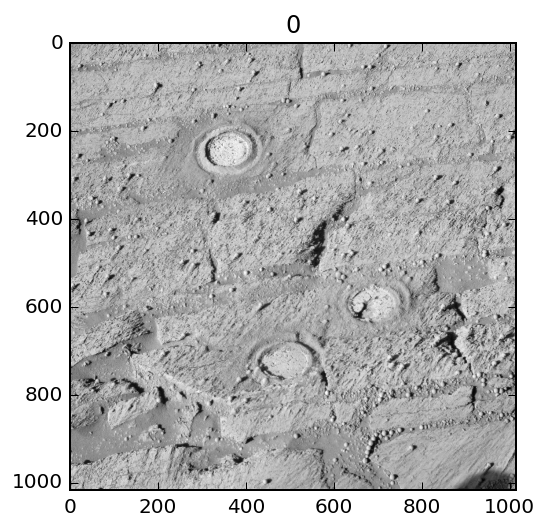

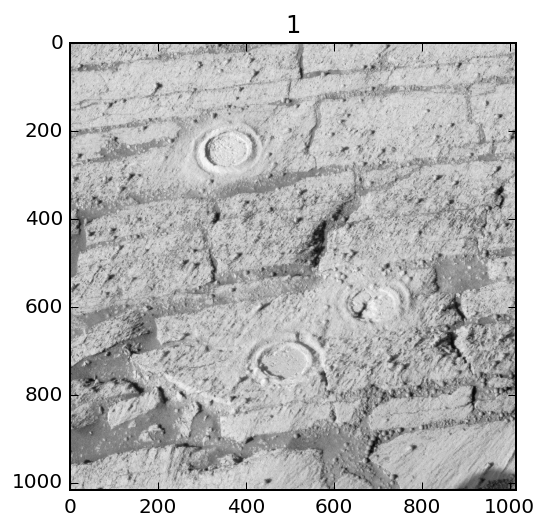

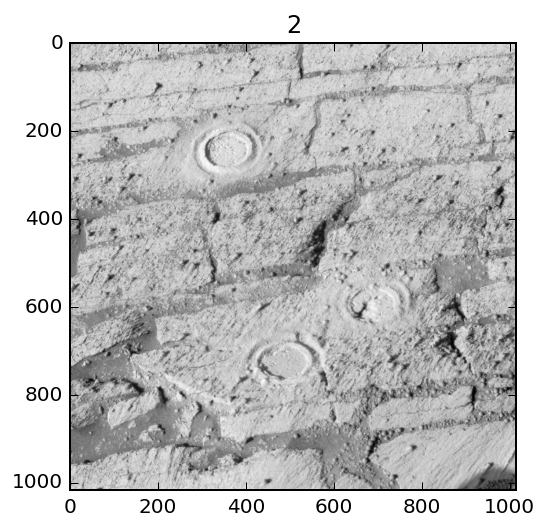

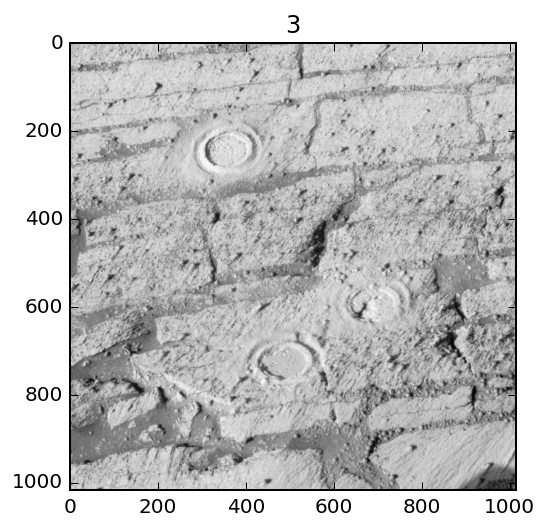

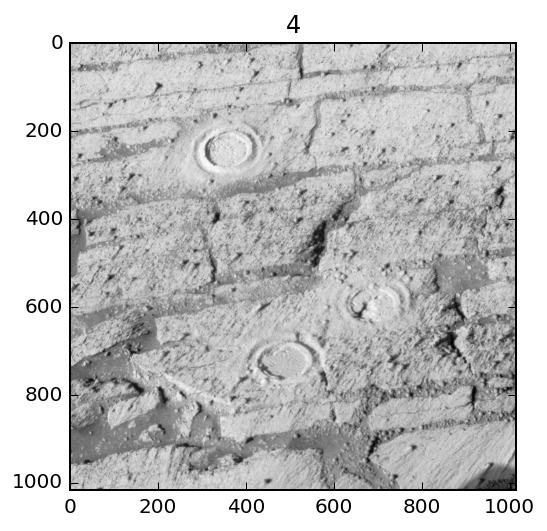

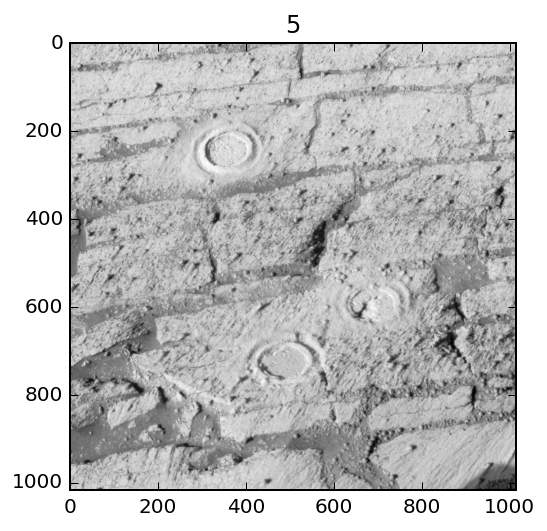

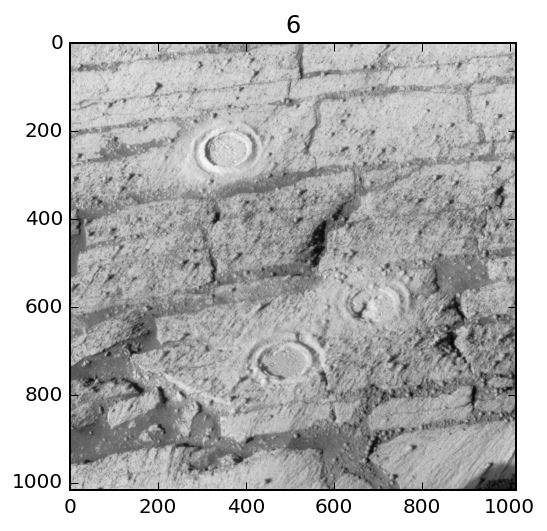

In [7]:

imgs = None
#R = np.zeros((len(data[sol][seq]),1016*1016))
R = np.zeros((len(x),1016*1016),dtype='uint8')
filter_number = []
count = -1
for i,filename in enumerate(data[sol][seq]):
    print filename
    if filename in x:
        print 'MATCH'
    else:
        print 'Failed to find a match!'
        continue
    count += 1
    URL = '{baseURL}{dataURL}sol{sol}/{product}/{filename}/0/raster/data[]{formatURL}'.format(baseURL=baseURL,
            dataURL=dataURL, sol='{0:0>4}'.format(sol), product=product, filename=filename, formatURL=formatURL)
    try:
        img = np.array(requests.get(URL).json()['data'],dtype='uint8')
    except:
        print 'Unable to retrieve from: {URL}'.format(URL=URL)
    #if i==3:
    #    print 'Adding a fake cosmic ray to img #3 at pixel location [800,400]'
#Made fake cosmic ray larger for testing purposes. Original img[798:802,398:402] = 255 
    #    img[790:810,390:410] = 255
    fimg = img[4:-4,4:-4].flatten()
    gimg = img[4:-4,4:-4]
    R[count] = fimg
    rebuild = gimg.shape
    filename_str = str(filename)
    filter_num = filename_str[24:-6]
    filter_number.append(filter_num)
    Path_name = 'Sol-{sol}/Seq-{seq}/filter-{i}'.format(sol=sol, seq=seq, i=filter_num)
    if not os.path.exists(Path_name):
        os.makedirs(Path_name)
        print 'Created Directory: {Path_name}'.format(Path_name=Path_name)
    f_name = '{Path_name}/{seq}_filter-{i}_ORIGINAL.fits'.format(Path_name=Path_name,seq=seq,i=filter_num)
    try:
        fig1 = plt.figure()
        plt.title('{i}'.format(i=i))
        plt.imshow(gimg,cmap = cm.Greys_r)
    except:
        print URL
    if os.path.exists(f_name):
        os.remove(f_name)
    hdu = fits.PrimaryHDU(gimg)
    hdulist = fits.HDUList([hdu])
    hdulist.writeto(f_name)
        



In [8]:
'''Produces the flattened eigenimages through principle component analysis.'''
Zn = PCA(R)

In [9]:
'''Save PCA output to FITS file.'''
'''Store eigenimages to dictionary'''
'''***Phase out fully shaped "components" in favor of the flattened arrays of Zn*** --01/19/2016'''
k,n = np.shape(Zn)
components = {}
for i in range(k):
    components[i] = {}
    ZnReshape = np.reshape(Zn[i],(rebuild))
    components[i] = ZnReshape
    Path_n = 'Sol-{sol}/Seq-{seq}/filter-{i}'.format(sol=sol,seq=seq,i=filter_number[i])
    fname = '{P_n}/{seq}_filter-{i}_PCA-OUTPUT.fits'.format(P_n=Path_n,seq=seq,i=filter_number[i])
    if os.path.exists(fname):
        os.remove(fname)
    hdu = fits.PrimaryHDU(ZnReshape)
    hdulist = fits.HDUList([hdu])
    hdulist.writeto(fname)


In [11]:
'''Plot all eigenimages against each other'''
'''N = Zn.shape[0]
for i in range(N):
    for j in range(N):
        if i==j:
            continue
        #if i!=3:
        #    continue

        plt.figure(figsize=(10,10))
        plt.title('{i}x{j}'.format(i=filter_number[i],j=filter_number[j]))
        #plt.axes([0,R.max(),0,R.max()])
        plt.plot(Zn[i,:],Zn[j,:],'.',alpha=0.25,color='k',markersize=5)
'''       

"N = Zn.shape[0]\nfor i in range(N):\n    for j in range(N):\n        if i==j:\n            continue\n        #if i!=3:\n        #    continue\n\n        plt.figure(figsize=(10,10))\n        plt.title('{i}x{j}'.format(i=filter_number[i],j=filter_number[j]))\n        #plt.axes([0,R.max(),0,R.max()])\n        plt.plot(Zn[i,:],Zn[j,:],'.',alpha=0.25,color='k',markersize=5)\n"

Below is progress as of 12/01/2015.

The process thusfar:
    1.) decompose a row into 4x4 or 5x5 "chunks" (later: enable decomposition of all rows in the component)
    2.) flatten the decomosition and aggregate it with flattened arrays of the x and y coordinates of points within the chunk. This will create a 3-D array representing x,y,m space.
    3.) Perform K-Means clustering over the x,y,m space array. This will provide a 1-D array containing the index for each point in the x,y,m space array.
    4.) relocate chunk-rows to their respective locations w.r.t. the component-row.
    5.) ***01/19/2016 This method is subject to review.***
    

In [12]:
'''1.) General component decomposition engine. Breaks down all rows for all components for the corresponding image.'''
'''(see the component decomposition function [above]...)'''
start_time = timeit.default_timer()
comp_decomp_dict = {}
for i in components:
    comp_decomp_dict[i] = {}
    comp_decomp = component_decomposition(components[i])
    comp_decomp_dict[i] = comp_decomp
elapsed = timeit.default_timer() - start_time
print elapsed

7.9560239315


In [13]:
'''sample of how to query comp_decomp_dict'''
'''(what a "chunk" looks like)'''
print comp_decomp_dict[6][0][0]

[[-0.00650056 -0.00609005 -0.00581479 -0.00610564]
 [-0.00613538 -0.00629073 -0.00529279 -0.00572967]
 [-0.00368192 -0.00532335 -0.00497159 -0.00557593]
 [-0.00344641 -0.00585036 -0.00564751 -0.00676477]]


In [14]:
'''2.) Pre-prepared arrays of x and y values'''
X_Vals = np.zeros((4,4))

for yy in range(len(X_Vals)):
    for xx in range(len(X_Vals)):
        X_Vals[yy][xx] = xx

Y_Vals = X_Vals.T
X_Vals_f = X_Vals.flatten()
Y_Vals_f = Y_Vals.flatten()

In [15]:
sample_f = comp_decomp_dict[6][0][0].flatten()

In [16]:
agg = np.array([X_Vals_f, Y_Vals_f, sample_f])

In [17]:
'''KMeans fit_predict'''
start_time = timeit.default_timer()
KM = KMeans(n_clusters=3, init='k-means++')
KM_index = KM.fit_predict(agg.T)
#print KM_index
elapsed = timeit.default_timer() - start_time
print elapsed

0.0268499851227


In [18]:
'''KMeans fit'''
start_time = timeit.default_timer()
KM = KMeans(n_clusters=3, init='k-means++')
KM_index = KM.fit(agg.T)
#print KM_index
elapsed = timeit.default_timer() - start_time
print elapsed

0.0145421028137


In [19]:
'''5.) Single index evaluation w.r.t x,y,m space values from individual chunk'''
'''for i,x in enumerate(Kchunky[0]):
    if x == 2:
        print agg_chunkT[0][i]'''

'for i,x in enumerate(Kchunky[0]):\n    if x == 2:\n        print agg_chunkT[0][i]'

In [20]:
'''4.) Relocate row-chunks to their respective component-row locations.'''
'''for i in range(len(agg_chunkT)):
    for x in range(len(agg_chunkT[i])):
        agg_chunkT[i][x][0] = agg_chunkT[i][x][0] + i'''

'for i in range(len(agg_chunkT)):\n    for x in range(len(agg_chunkT[i])):\n        agg_chunkT[i][x][0] = agg_chunkT[i][x][0] + i'

In [21]:
'''This will take ~20 hrs. as is...'''
'''agg = {}
KMs = {}
for i in comp_decomp_dict:
    agg[i] = {}
    KMs[i] = {}
    for row in range(len(comp_decomp_dict[i])):
        row_agg = []
        row_KM = []
        agg[i][row] = {}
        KMs[i][row] = {}
        for sample in range(len(comp_decomp_dict[i][row])):
            #agg[i][row] = {}
            #KM[i][row] = {}
            sample_f = comp_decomp_dict[i][row][sample].flatten()
            agg_chunk = np.array([X_Vals_f, Y_Vals_f, sample_f])
            row_agg.append(agg_chunk.T)
            KM = KMeans(n_clusters=3, init='k-means++')
            KM_index = KM.fit_predict(agg_chunk.T)
            row_KM.append(KM_index)
        agg[i][row] = row_agg
        KMs[i][row] = row_KM'''

"agg = {}\nKMs = {}\nfor i in comp_decomp_dict:\n    agg[i] = {}\n    KMs[i] = {}\n    for row in range(len(comp_decomp_dict[i])):\n        row_agg = []\n        row_KM = []\n        agg[i][row] = {}\n        KMs[i][row] = {}\n        for sample in range(len(comp_decomp_dict[i][row])):\n            #agg[i][row] = {}\n            #KM[i][row] = {}\n            sample_f = comp_decomp_dict[i][row][sample].flatten()\n            agg_chunk = np.array([X_Vals_f, Y_Vals_f, sample_f])\n            row_agg.append(agg_chunk.T)\n            KM = KMeans(n_clusters=3, init='k-means++')\n            KM_index = KM.fit_predict(agg_chunk.T)\n            row_KM.append(KM_index)\n        agg[i][row] = row_agg\n        KMs[i][row] = row_KM"

In [22]:
agg_row = [threeD(chunk) for chunk in comp_decomp_dict[0][0]]
KM_row = [kmeans_row(agg_chunk) for agg_chunk in agg_row]

Below is an attempt to verify the existence of cosmic rays using clustering over regions of interest found using Glueviz. This method will remove the region of interest from the component and have a clustering method run over it. This represents progress as of 12/08/15

In [23]:
def kmeans_verification(comp):
    y_top = 1015 - (555 + 8)
    y_bot = 1015 - (548 - 5)
    region = comp[y_top:y_bot,0:20]
    X_Vals = np.zeros((len(region),len(region.T)))
    for yy in range(len(X_Vals)):
        for xx in range(len(X_Vals)):
            X_Vals[yy][xx] = xx
    Y_Vals = X_Vals.T
    X_Vals_f = X_Vals.flatten()
    Y_Vals_f = Y_Vals.flatten()
    regxym = (np.array([X_Vals_f, Y_Vals_f, region.flatten()])).T
    KM = KMeans(n_clusters=8, init='k-means++')
    KM_index = KM.fit_predict(regxym)
    regxym_zero = []
    regxym_one = []
    regxym_two = []
    regxym_tre = []
    regxym_for = []
    regxym_fiv = []
    regxym_six = []
    regxym_sev = []
    for i,index in enumerate(KM_index):
        if index == 0:
            regxym_zero.append(regxym[i])
        elif index == 1:
            regxym_one.append(regxym[i])
        elif index == 2:
            regxym_two.append(regxym[i])
        elif index == 3:
            regxym_tre.append(regxym[i])
        elif index == 4:
            regxym_for.append(regxym[i])
        elif index == 5:
            regxym_fiv.append(regxym[i])
        elif index == 6:
            regxym_six.append(regxym[i])
        elif index == 7:
            regxym_sev.append(regxym[i])
        else:
            continue
    '''0 index cluster'''
    regxym_zero_x = ((np.array(regxym_zero)).T)[0]
    regxym_zero_y = ((np.array(regxym_zero)).T)[1]

    '''1 index cluster'''
    regxym_one_x = ((np.array(regxym_one)).T)[0]
    regxym_one_y = ((np.array(regxym_one)).T)[1]

    '''2 index cluster'''
    regxym_two_x = ((np.array(regxym_two)).T)[0]
    regxym_two_y = ((np.array(regxym_two)).T)[1]
    
    '''3 index cluster'''
    regxym_tre_x = ((np.array(regxym_tre)).T)[0]
    regxym_tre_y = ((np.array(regxym_tre)).T)[1]
    
    '''4 index cluster'''
    regxym_for_x = ((np.array(regxym_for)).T)[0]
    regxym_for_y = ((np.array(regxym_for)).T)[1]
    
    '''5 index cluster'''
    regxym_fiv_x = ((np.array(regxym_fiv)).T)[0]
    regxym_fiv_y = ((np.array(regxym_fiv)).T)[1] 
    
    '''6 index cluster'''
    regxym_six_x = ((np.array(regxym_six)).T)[0]
    regxym_six_y = ((np.array(regxym_six)).T)[1] 
    
    '''7 index cluster'''
    regxym_sev_x = ((np.array(regxym_sev)).T)[0]
    regxym_sev_y = ((np.array(regxym_sev)).T)[1] 

    return (regxym_zero_x, regxym_zero_y, regxym_one_x, regxym_one_y, regxym_two_x, regxym_two_y, regxym_tre_x,
           regxym_tre_y, regxym_for_x, regxym_for_y, regxym_fiv_x, regxym_fiv_y, regxym_six_x, regxym_six_y,
           regxym_sev_x, regxym_sev_y)

4.11961698532


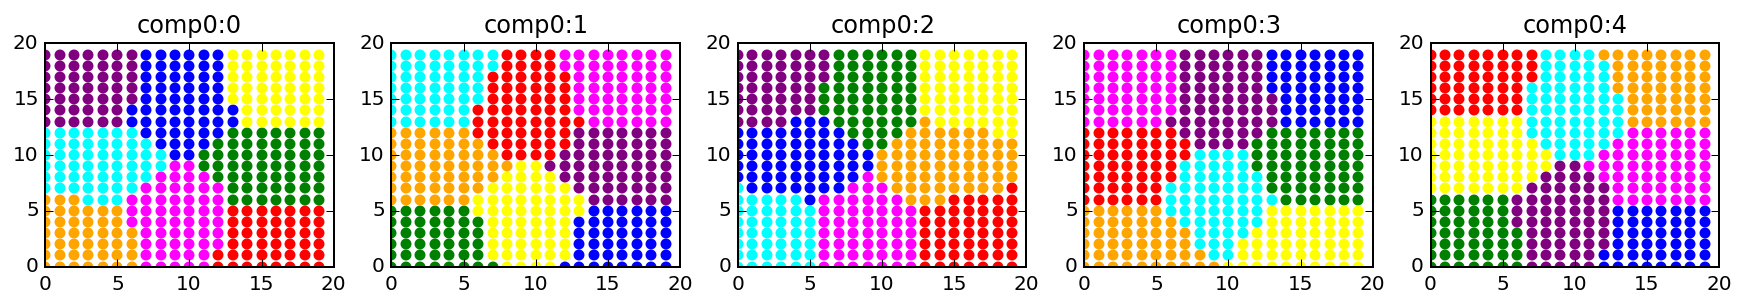

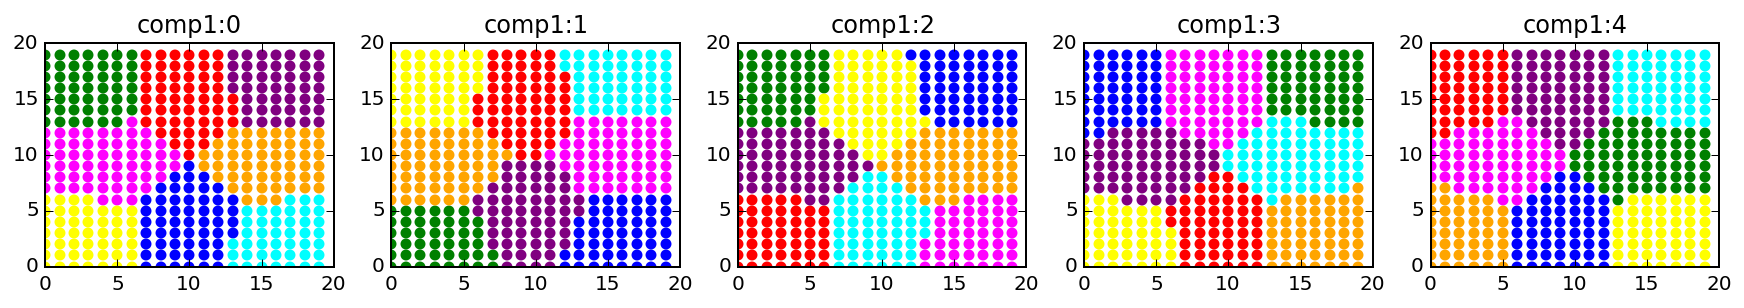

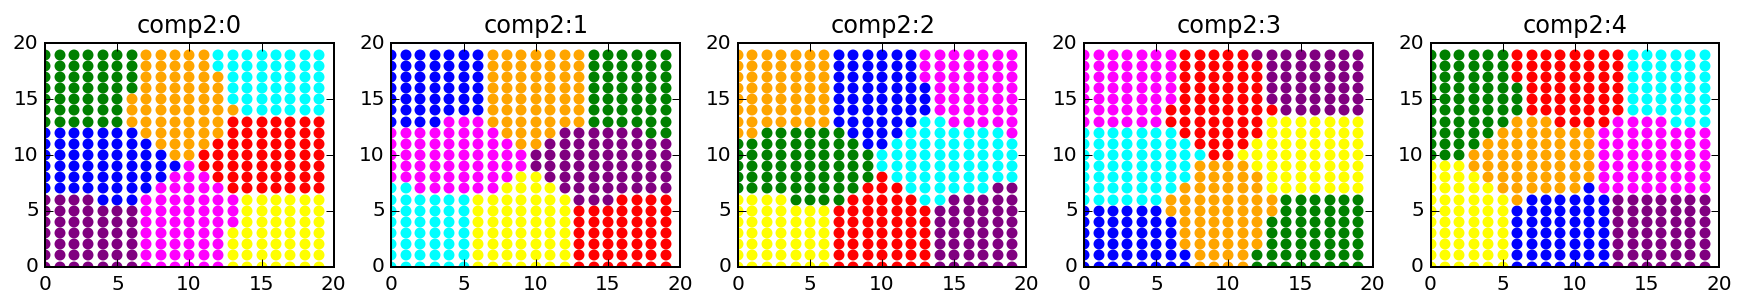

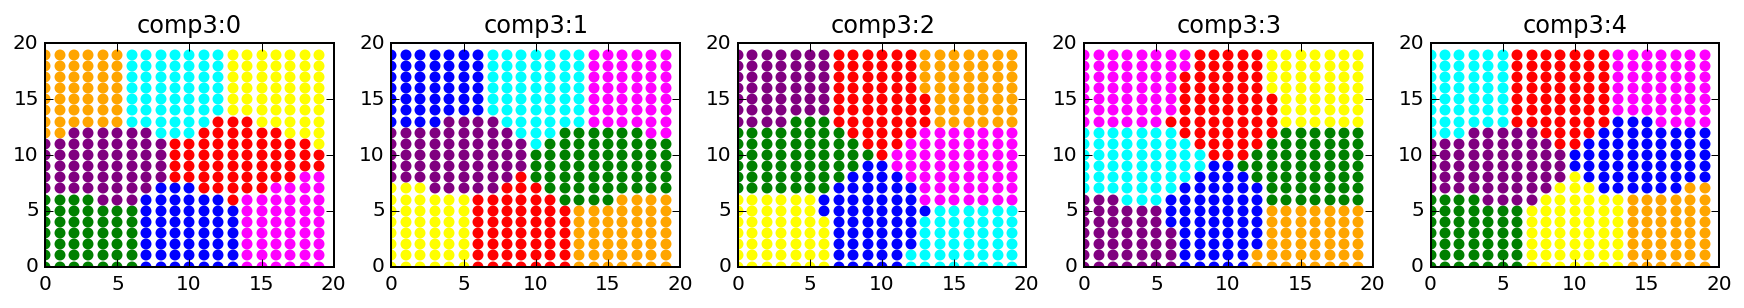

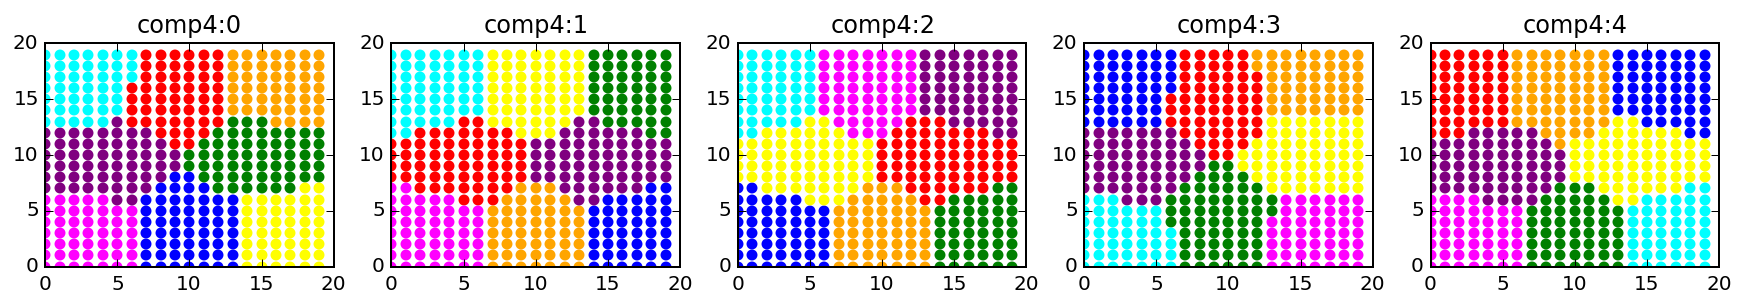

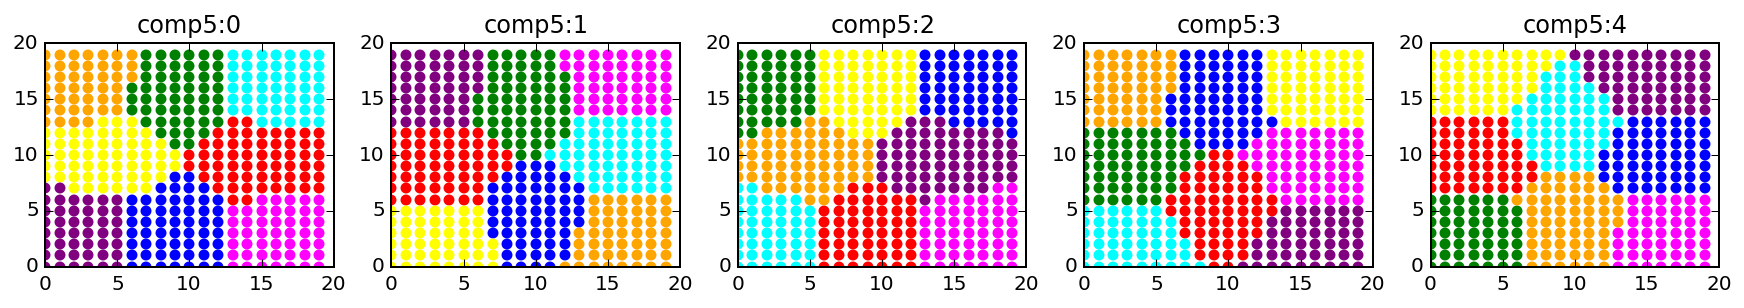

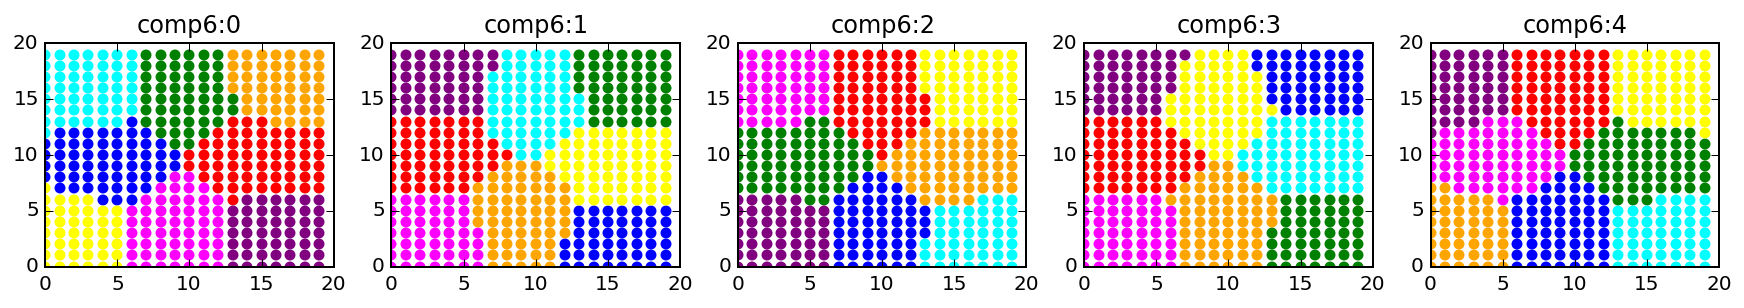

In [24]:
''' KMeans cluster analysis testing. (see the function <Kmeans verification> above)'''
start_time = timeit.default_timer()

for i in range(len(components)):
    fig = plt.figure(figsize(15,2))
    for j in range(5):
        zerx,zery,onex,oney,twox,twoy,trex,trey,forx,fory,fivx,fivy,sixx,sixy,sevx,sevy = kmeans_verification(components[i])
        plt.subplot2grid((1,5),(0,j))
        plt.xlim(0,20)
        plt.ylim(0,20)
        plt.title('comp{i}:{j}'.format(i=i,j=j))
        plt.scatter(zerx,zery,color='blue')
        plt.scatter(onex,oney,color='red')
        plt.scatter(twox,twoy,color='green')
        plt.scatter(trex,trey,color='magenta')
        plt.scatter(forx,fory,color='yellow')
        plt.scatter(fivx,fivy,color='orange')
        plt.scatter(sixx,sixy,color='purple')
        plt.scatter(sevx,sevy,color='cyan')

elapsed = timeit.default_timer() - start_time
print elapsed

Three Clusters: No sign of an anomaly. 3.079s to compute.
five clusters: possible sign of the anomaly. 4.138s to compute.
eight clusters: Any sign of the anomaly has been washed out. 4.59s to compute.

In [25]:
'''k_test = np.zeros((20,20))
for i in range(len(k_test)):
    for j in range(len(k_test[0])):
        k_test[i][j] = randint(0,9)
k_test[2:len(k_test)-2,2:len(k_test.T)-2] = 200

for x in range(5):
    zerx,zery,onex,oney,twox,twoy,trex,trey,forx,fory,fivx,fivy,sixx,sixy,sevx,sevy = kmeans_verification(k_test)
    plt.subplot2grid((1,5),(0,x))
    plt.xlim(0,20)
    plt.ylim(0,20)
    plt.title('comp:{x}'.format(x=x))
    plt.scatter(zerx,zery,color='blue')
    plt.scatter(onex,oney,color='red')
    plt.scatter(twox,twoy,color='green')
    plt.scatter(trex,trey,color='magenta')
    plt.scatter(forx,fory,color='yellow')
    plt.scatter(fivx,fivy,color='orange')
    plt.scatter(sixx,sixy,color='purple')
    plt.scatter(sevx,sevy,color='cyan')'''

"k_test = np.zeros((20,20))\nfor i in range(len(k_test)):\n    for j in range(len(k_test[0])):\n        k_test[i][j] = randint(0,9)\nk_test[2:len(k_test)-2,2:len(k_test.T)-2] = 200\n\nfor x in range(5):\n    zerx,zery,onex,oney,twox,twoy,trex,trey,forx,fory,fivx,fivy,sixx,sixy,sevx,sevy = kmeans_verification(k_test)\n    plt.subplot2grid((1,5),(0,x))\n    plt.xlim(0,20)\n    plt.ylim(0,20)\n    plt.title('comp:{x}'.format(x=x))\n    plt.scatter(zerx,zery,color='blue')\n    plt.scatter(onex,oney,color='red')\n    plt.scatter(twox,twoy,color='green')\n    plt.scatter(trex,trey,color='magenta')\n    plt.scatter(forx,fory,color='yellow')\n    plt.scatter(fivx,fivy,color='orange')\n    plt.scatter(sixx,sixy,color='purple')\n    plt.scatter(sevx,sevy,color='cyan')"

Kmeans does not appear to be sensitive enough for our purposes. Below is some experimentation to try and find a better method.

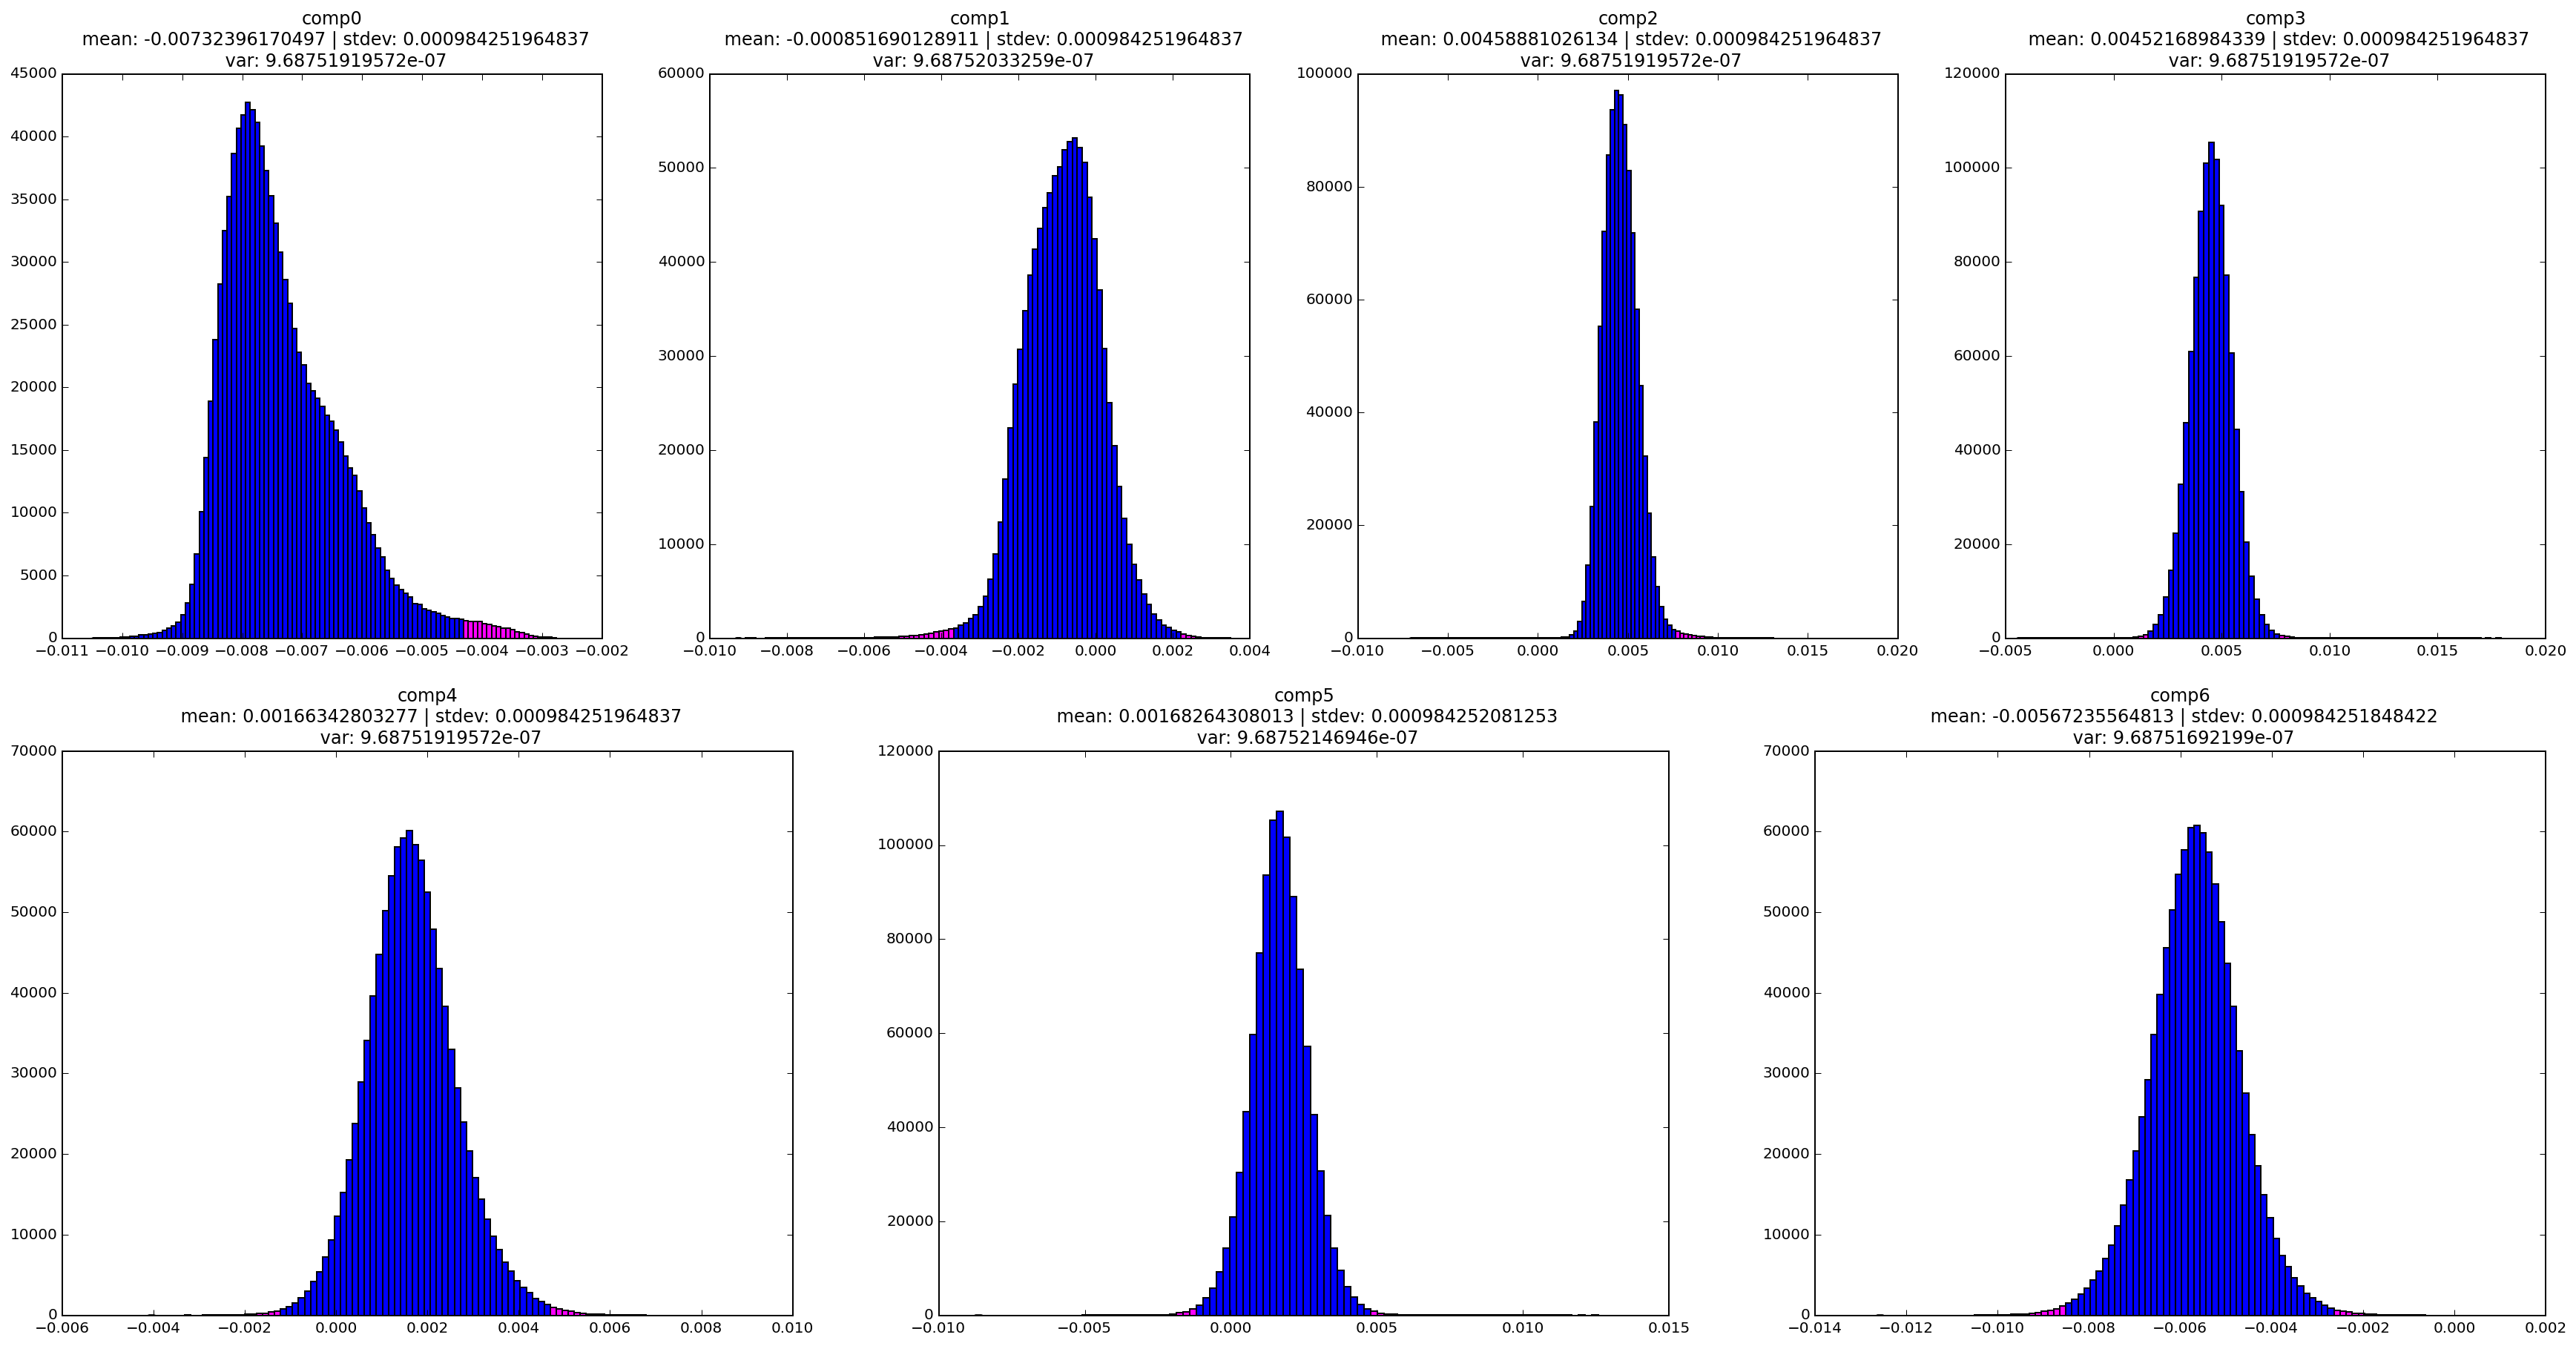

In [26]:
'''Needs to be updated to use Zn instead of components'''
'''Displays the distribution of data within the eigenimages'''
fig1 = plt.figure(figsize(30,15))
col = 4
j = 0
counti = -1
countii = -1
for i in range(len(components)):
    mean = np.mean(components[i].flatten())
    stdev = np.std(components[i].flatten())
    var = np.var(components[i].flatten())
    counti += 1
    if i >= 4:
        j = 1
        col = 3
        countii += 1
        counti = countii
    plt.subplot2grid((2,col),(j,counti))
    n,bins,patches = plt.hist(components[i].flatten(),100)
    plt.title('comp{i}\n mean: {mean} | stdev: {stdev}\n var: {var}'.format(i=i, mean=mean, stdev=stdev, var=var))
    for N,Patch,Bins in zip(n,patches,bins):
        if Bins > (mean + 3*stdev) or Bins < (mean - 3*stdev):
            Patch.set_facecolor('magenta')

In [27]:
'''Work post 12/17/2015'''
'''Verifies percentile cut values from R w.r.t eigenimages'''
xyhits = percentile_cut(Zn[0])
R_ver_arr = []
for i in R:
    R_ver = verify_R2Comp(xyhits,i)
    R_ver_arr.append(R_ver)

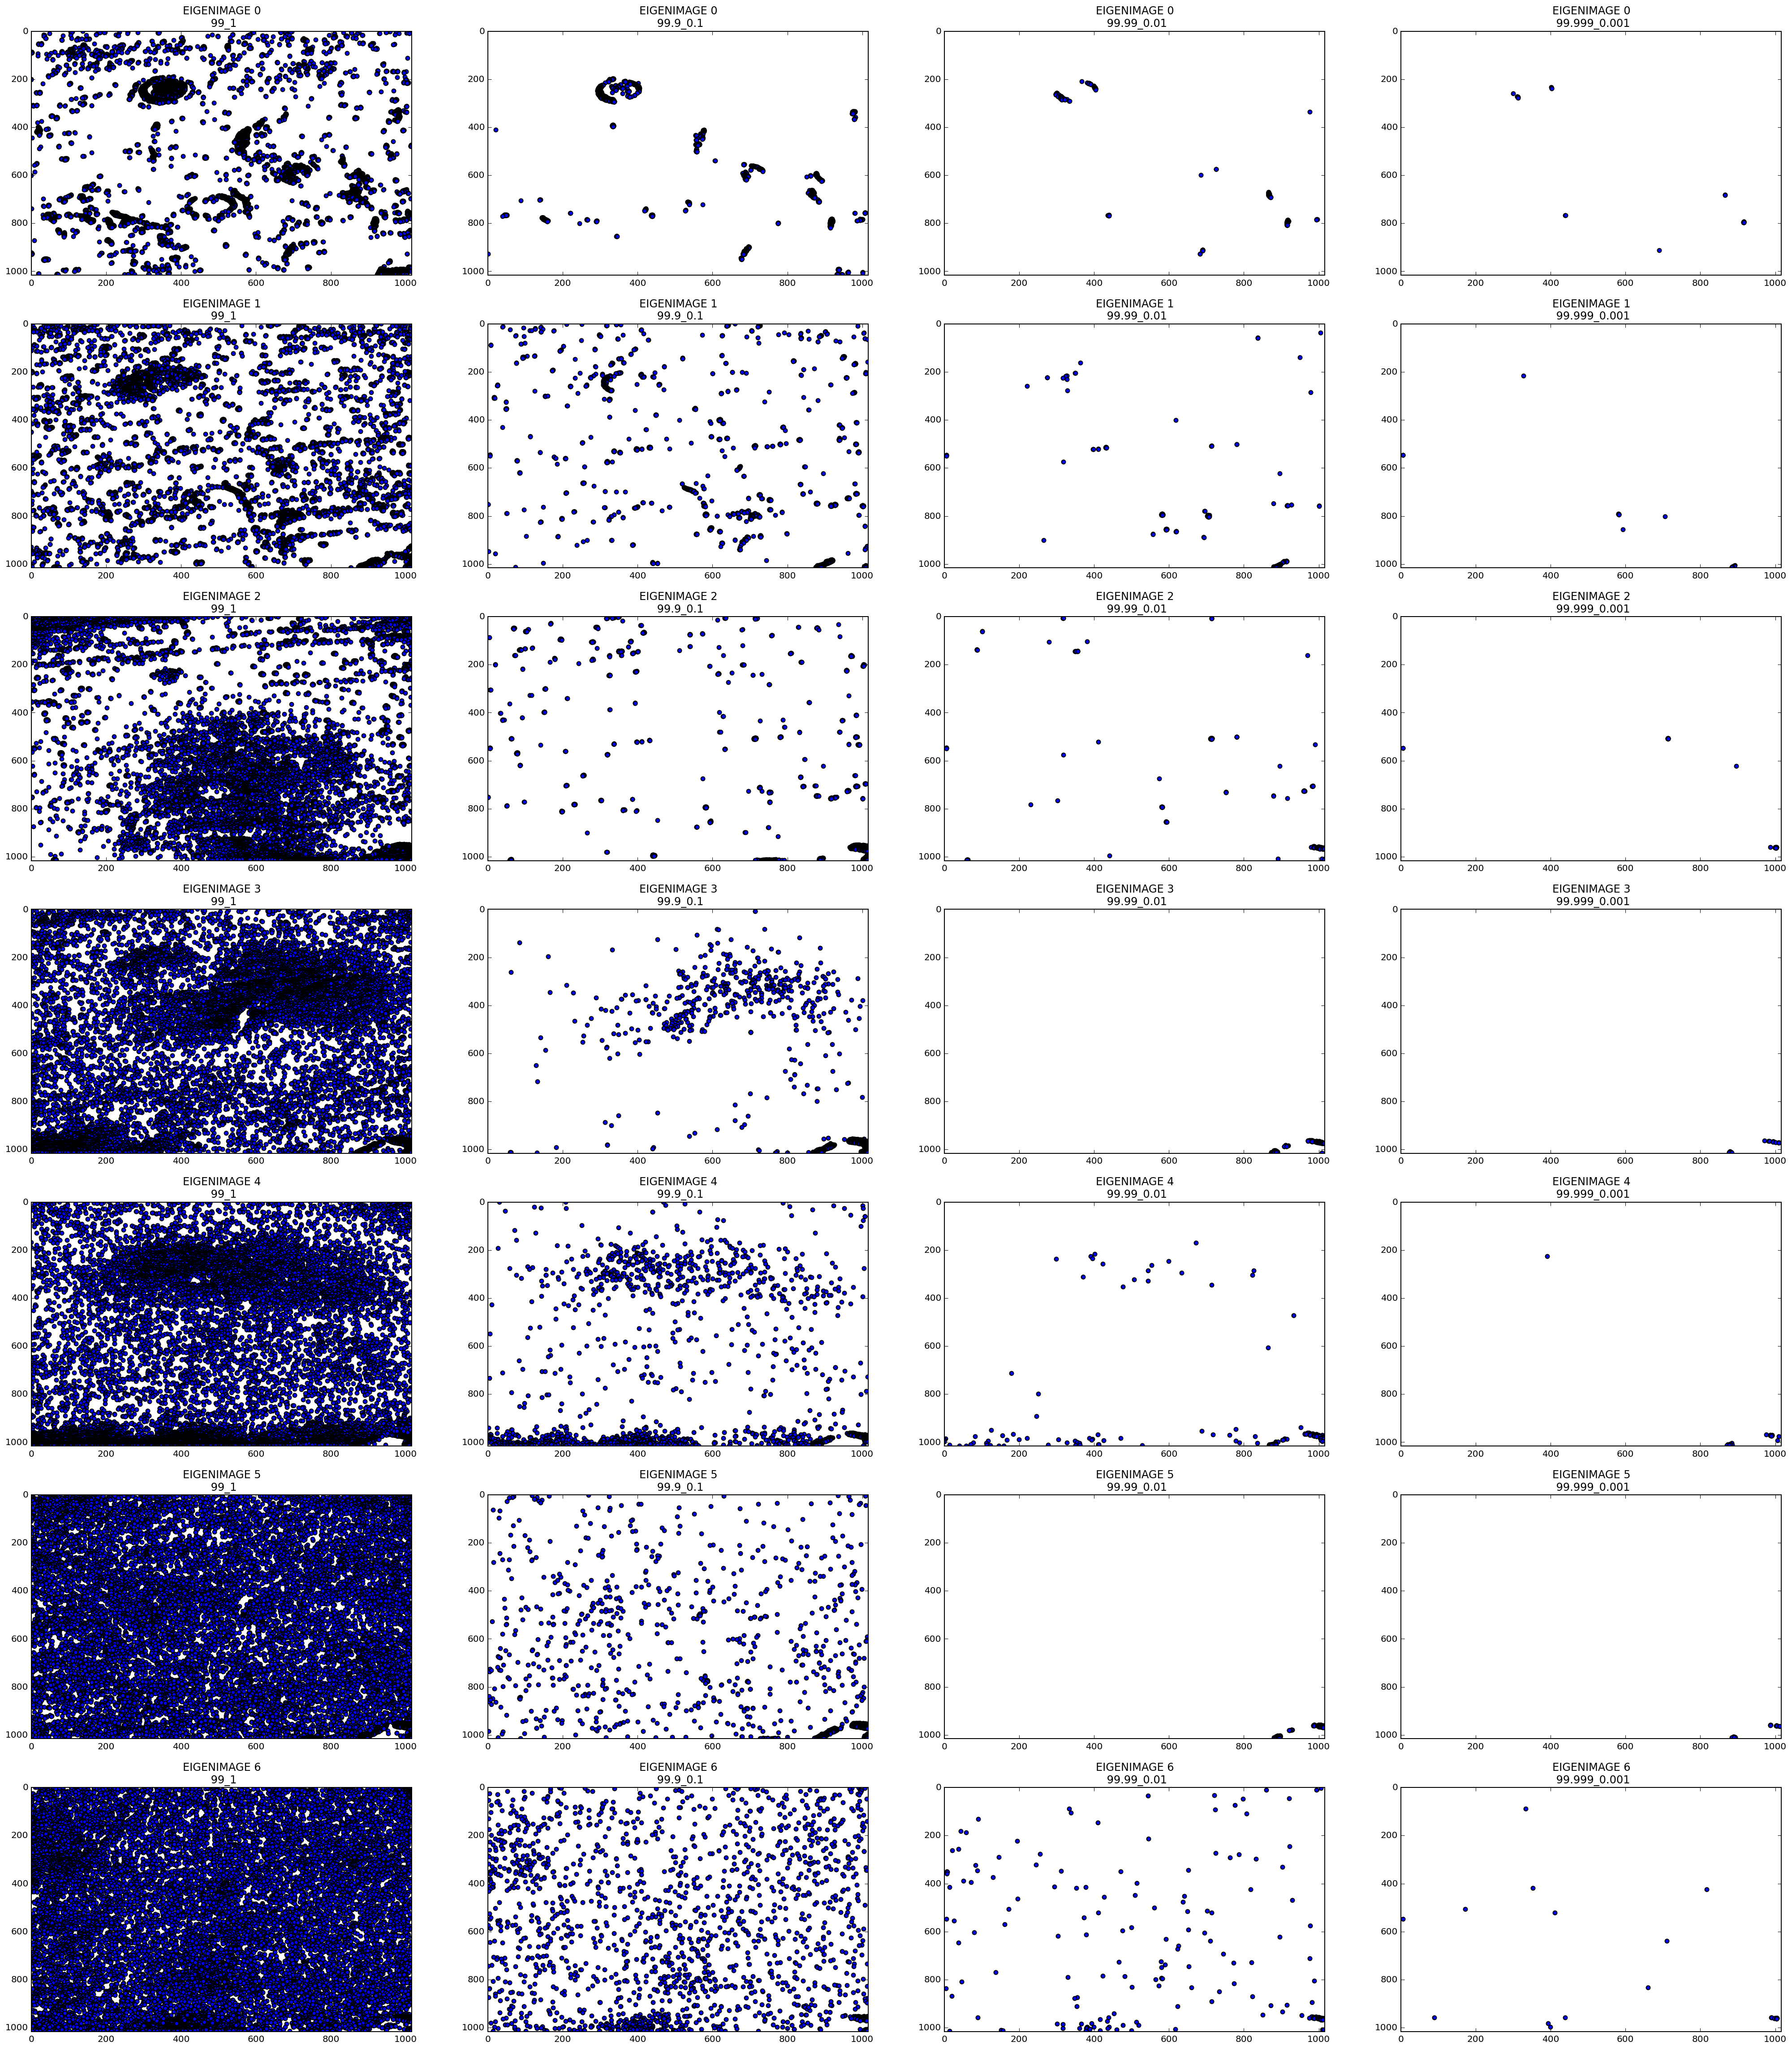

In [321]:
'''Work prior to 12/17/2015--updated 01/18/2016-- Plots all percentile cuts for all eigenimages'''
figure_three = plt.figure(figsize(35,40))
for j in range(len(Zn)):
    xyhits = percentile_cut(Zn[j])
    eigen_img = np.reshape(Zn[j],rebuild)
    for i,key in enumerate(xyhits.keys()):
        plt.subplot2grid((len(Zn),4),(j,i))
        plt.scatter(xyhits[key]['x'],xyhits[key]['y'])
        plt.xlim(0,len(eigen_img[0]))
        plt.ylim(len(eigen_img[0].T),0)
        plt.title('EIGENIMAGE {j}\n {key}'.format(j=j, key=key))

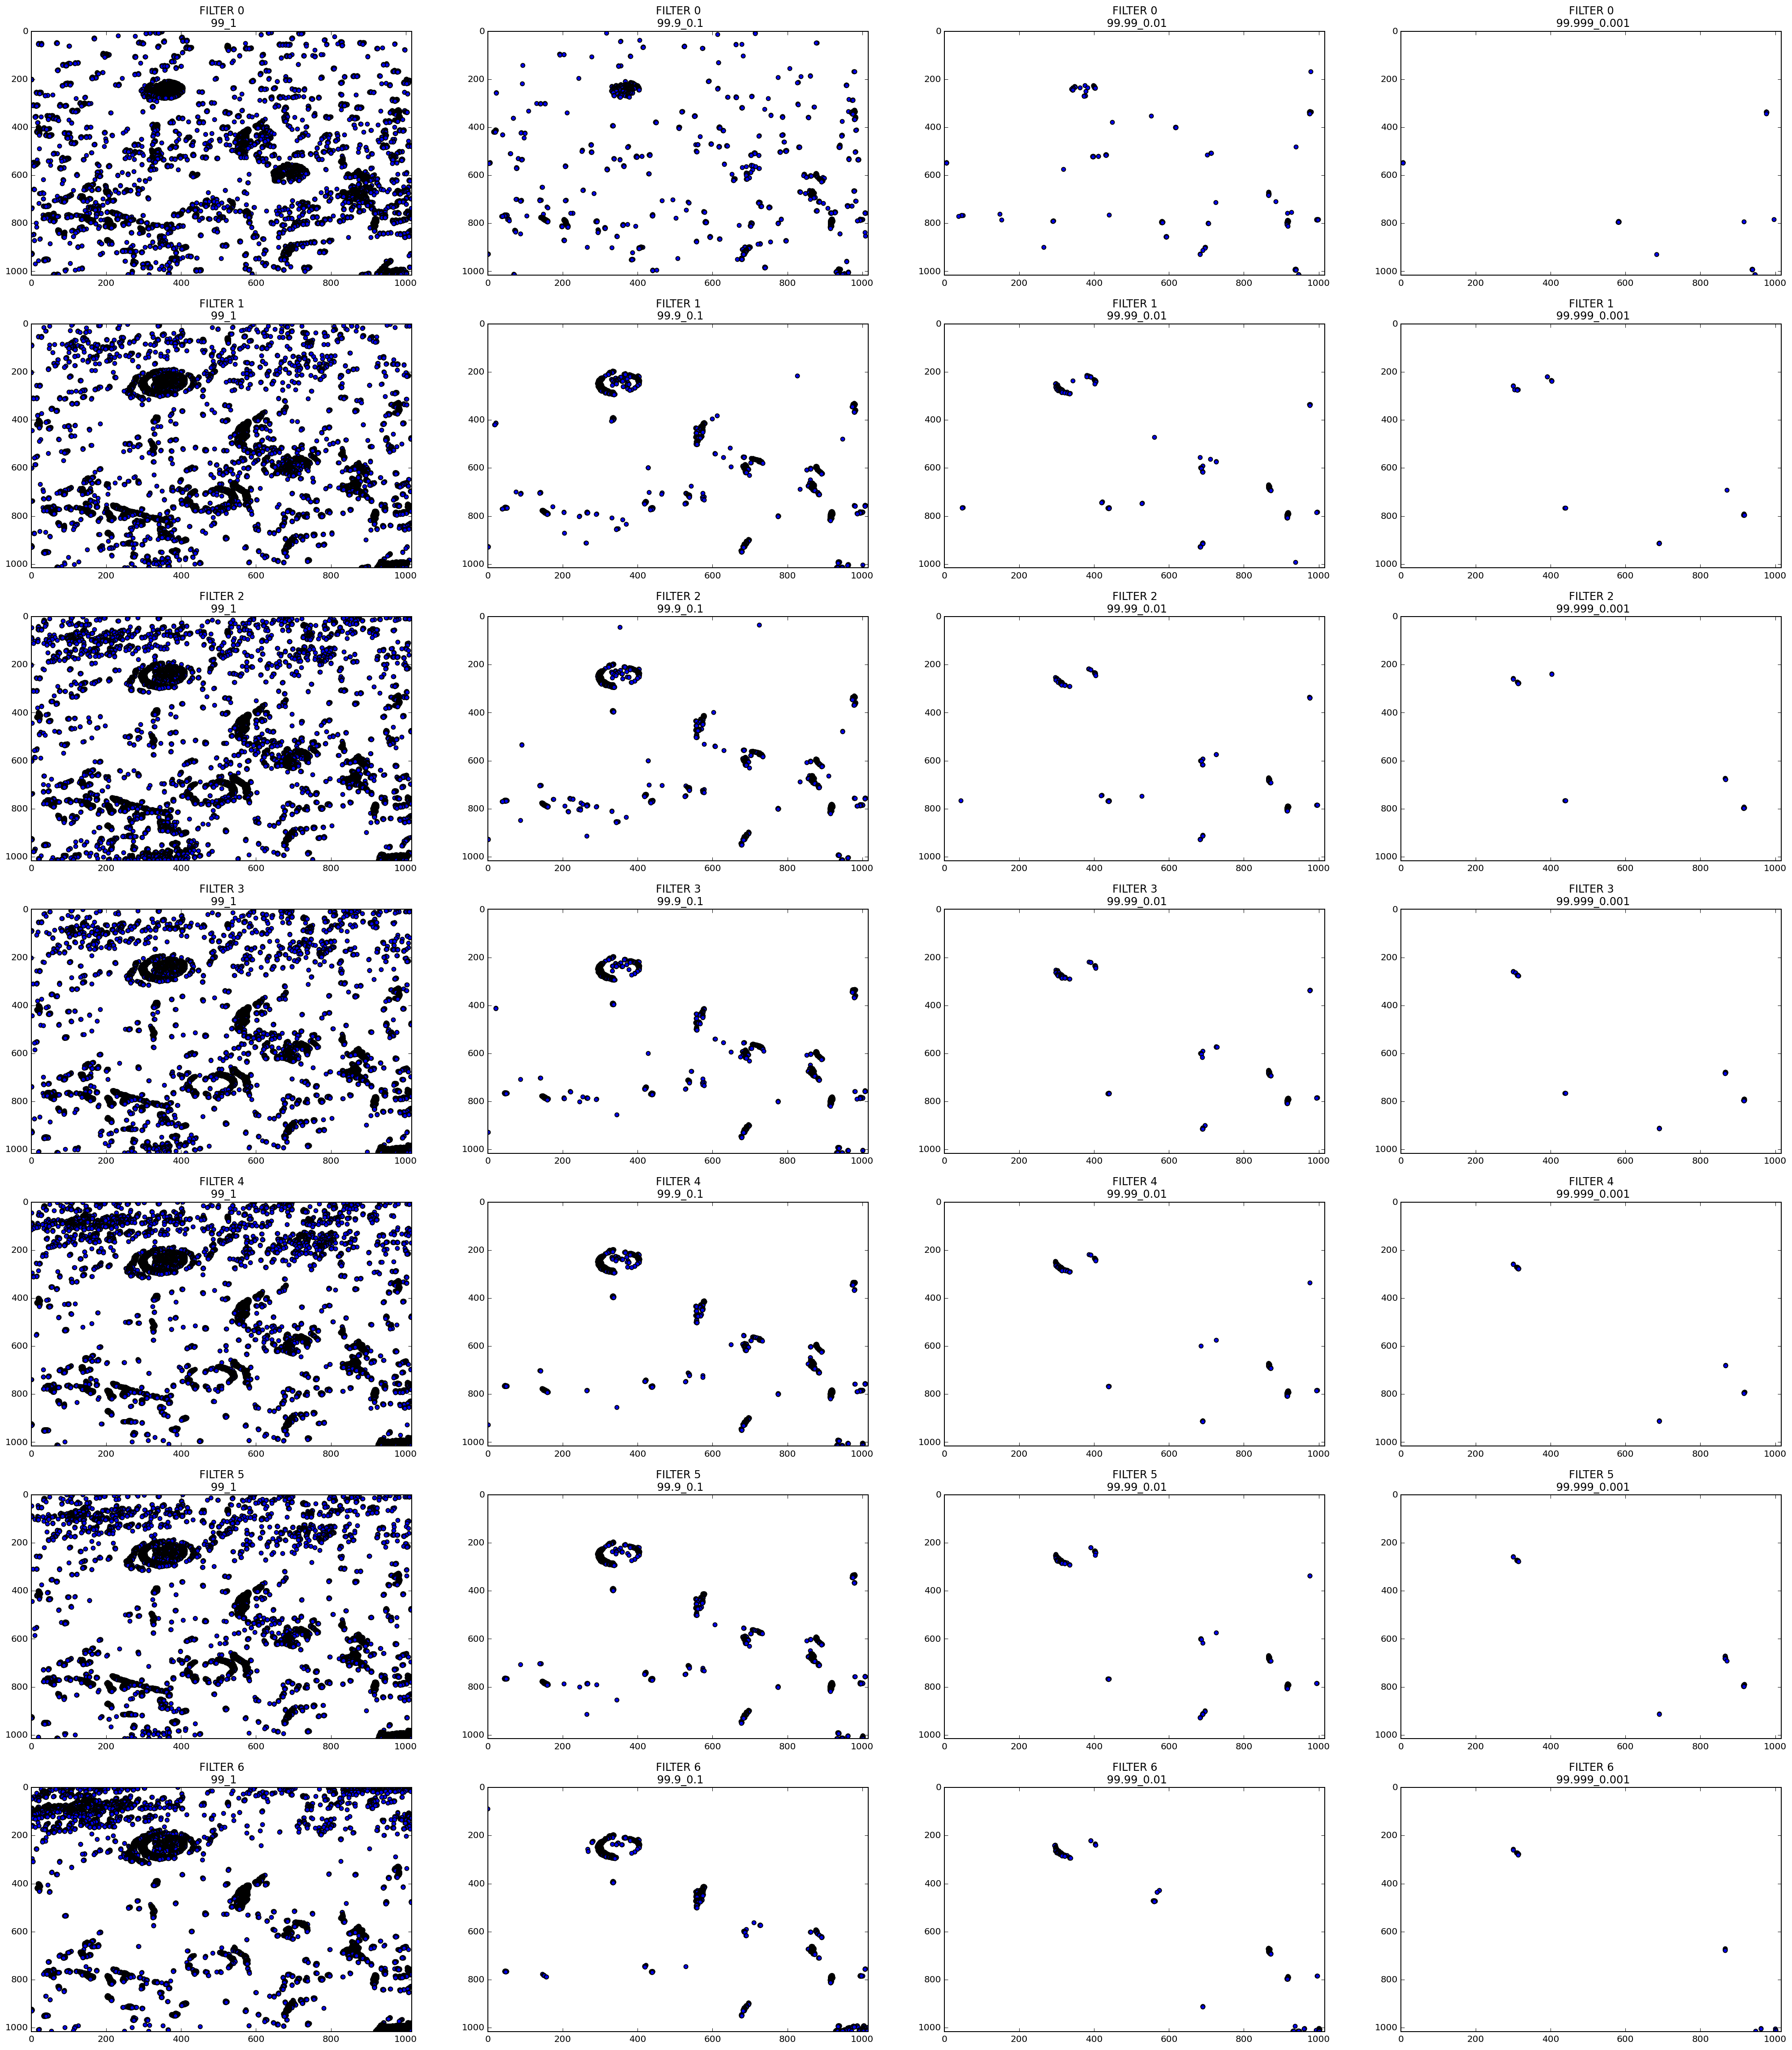

In [29]:
'''displays the output of verify_R2Comp. Each point on the grid represents an anomaly (and possible cosmic ray hit)
   for each image and their respective percentile cuts.'''
figure_four = plt.figure(figsize(35,40))
for j in range(len(R_ver_arr)):
    for i,key in enumerate(R_ver_arr[j].keys()):
        plt.subplot2grid((len(R_ver_arr),4),(j,i))
        plt.scatter(R_ver_arr[j][key]['x'], R_ver_arr[j][key]['y'])
        plt.xlim(0,len(components[0]))
        plt.ylim(len(components[0].T),0)
        plt.title('FILTER {j}\n {key}'.format(j=j,key=key))

In [919]:
The_End = collections.OrderedDict()
for key in xyhits.keys():
    The_End[key] = {}
    hits = cosmicray_hits(key,R_ver_arr)
    The_End[key] = hits